# **Entrenamiento del clasificador SVM con Kernel Gaussiano**

---
Este notebook detalla el procedimiento de entrenamiento del clasificador SVM con Kernel Gaussiano para la clasificación de líneas de texto y líneas de ecuaciones en regiones de texto utilizando como características a la técnica de Bag of  Words y características geométricas de píxeles.


## **1. Instalación de librerías para el funcionamiento de este Notebook en Google Colab**

In [ ]:
#Librería para autenticación cuenta de google drive
!pip install -U -q PyDrive
#Librería Dask para lectura de datos
! python -m pip install "dask[complete]"

## **2. Importación de librerías**

In [ ]:
# 1. Authenticación y creación the PyDrive client
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# 2.Ejecuta esta celda para activar Google Drive.
from google.colab import drive as d
d.mount('/content/drive')

In [ ]:
# 3. importación de librerías para el diseño y entrenamiento de la red neuronal
import os
import itertools
import h5py
import dask.dataframe as dd
import plotly.express as px
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn import mixture 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import hinge_loss

In [ ]:
# 3. Se especifica directorios de trabajo
"""Se especifica la dirección del área de trabajo"""
os.chdir('/content/drive/My Drive/DocLayoutEPN')

"""Se especifica una dirección para procesos temporales"""
temp_dir = '/content'

In [ ]:
# 4. Importar funciones auxiliares para el funcionamiento de este notebook 
import import_ipynb
from CNNTraining.AuxiliarFunctions import plot_confusion_matrix

## **3. Importar el conjunto de datos para el entrenamiento y el metadata**

---

Se importa al directorio temporal un conjunto  de datos conformado por vectores de 259 elementos, etiquetados en dos categorías (línea de texto y línea de ecuación). Cada elemento del vector global de características contiene la siguiente información:



*   Los 3 primeros elementos del vector representan información estadística extraída directamente de la geometría presente en los píxeles que componen una línea.
*   Los 256 elementos son el resultado de la técnica Bag of Visual Words considerandocomo extractor de características los momentos de Zernike de los símbolos contenidosen cada una de las líneas de una región de texto.

Se tiene 4 base de datos distintas almacenados con los siguientes nombres:


*   pool1.zip
*   pool3.zip
*   pool5.zip
*   pool7.zip


A continuación se descomprime de la base de datos pool5.zip










In [ ]:
#Importación y descompresión de la base de datos en el directorio temporal
number_pool = 5
path_global_vectors = os.path.join('Database/FeaturesSVMGaussian','pool'+str(number_pool)+'.zip')
! unzip -q {path_global_vectors} -d {temp_dir}

Se carga el metada de las regiones de texto de donde fueron extraídas las líneas de texto y ecuación

In [ ]:
#Se carga el metadata con la información de las regiones de donde
# se extrajeron las líneas de ecuación y texto como un Panda Dataframe
path_database = os.path.join(temp_dir,'pool'+str(number_pool))
files_pool = os.listdir(path_database)
list_name_files =  list(map(lambda x:x[:-4],files_pool))
df  = pd.read_csv('Database/MetadataSymbols.csv')
DF = df[df['Identifier'].isin(list_name_files)]
DF.head(10)

,CoodX,CoodY,Width,Height,Class,Number_page,Height_Page,Width_Page,Folder,Page,Identifier
68844,2183,2513,1710,69,equation,page1.png,5500,4250,pdf2141,page1.png,reg230118
68845,356,3979,1710,78,equation,page2.png,5500,4250,pdf2141,page2.png,reg230126
68846,2183,3574,1710,60,equation,page2.png,5500,4250,pdf2141,page2.png,reg230127
68847,2183,3158,1710,164,equation,page2.png,5500,4250,pdf2141,page2.png,reg230128
68848,2183,2744,1710,69,equation,page2.png,5500,4250,pdf2141,page2.png,reg230129
68849,2183,1871,1710,159,equation,page2.png,5500,4250,pdf2141,page2.png,reg230130
68850,2183,634,1710,483,equation,page4.png,5500,4250,pdf2141,page3.png,reg230140
68851,356,4687,1710,74,equation,page5.png,5500,4250,pdf2141,page4.png,reg230145
68852,356,3372,1710,69,equation,page5.png,5500,4250,pdf2141,page4.png,reg230146
68853,356,1424,1710,165,equation,page5.png,5500,4250,pdf2141,page4.png,reg230147


Se han extrído líneas de texto y ecuación de la siguiente cantidad de regiones

In [ ]:
DF['Class'].value_counts()

equation      14589
block_text    11728
Name: Class, dtype: int64

### **3.1 Construcción de una base de datos balanceado**


Se construye una base de datos donde cada categoría tenga un número similar de datos.
Para tener similar cantidad de líneas de texto con líneas de ecuaciones, seleccionamos una cantidad menor de regiones de texto que regiones de ecuación

In [ ]:
# Extracción de datos con etiqueta de línea de texto
text_samples = 800
Text_lines_processing = DF[DF['Class'].isin(["block_text"])].sample(n=text_samples, random_state=497)

# Extracción de datos con etiqueta de línea de ecuación
equation_samples = int(3.5*text_samples)
Eq_lines_processing = DF[DF['Class'].isin(["equation"])].sample(n=equation_samples, random_state=12)

# Concatenación de los datos extraidos
svm_database = pd.concat([Text_lines_processing,Eq_lines_processing],ignore_index='True').sample(frac=1,random_state=100)

Se carga los vectores globales de las líneas contenidas por las regiones anteriormente seleccionadas

In [ ]:
dir_pool_csv =  list(map(lambda x:path_database+'/'+x+'.csv', svm_database['Identifier']))
text_eq_db = dd.read_csv(dir_pool_csv)
text_eq_db = text_eq_db.loc[:,'Centroid_fluct':'Identifier']
text_eq_db.head(n=10, npartitions=40)

,Centroid_fluct,HeighVar,Sparse_R,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,...,F219,F220,F221,F222,F223,F224,F225,F226,F227,F228,F229,F230,F231,F232,F233,F234,F235,F236,F237,F238,F239,F240,F241,F242,F243,F244,F245,F246,F247,F248,F249,F250,F251,F252,F253,F254,F255,lineName,Class,Identifier
0,0.330579,160.934154,0.151532,0,5,0,0,0,0,0,0,0,0,0,0,0,0,9,2,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,1,...,0,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,line1,block_text,reg250323
1,0.355882,161.071740,0.177259,0,6,0,0,0,0,0,0,0,0,0,0,0,0,6,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,line2,block_text,reg250323
2,0.301060,152.202479,0.158442,0,7,0,0,0,0,0,0,0,0,0,0,0,0,9,1,3,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,0,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,line3,block_text,reg250323
3,0.169607,107.103733,0.095658,0,2,0,0,0,0,0,0,0,0,0,0,0,0,8,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,line4,block_text,reg250323
4,0.361438,207.778837,0.168803,0,4,0,0,0,0,0,0,0,0,0,0,0,0,5,1,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,5,...,0,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,line5,block_text,reg250323
5,0.319129,175.721074,0.140434,0,4,0,0,0,1,0,0,0,0,0,0,0,0,7,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,3,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,line6,block_text,reg250323
6,0.282591,139.070727,0.159336,0,6,0,0,0,0,0,0,0,0,0,0,0,0,9,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,line7,block_text,reg250323
7,0.296477,226.068579,0.107425,0,5,0,0,0,0,0,0,0,0,2,0,0,0,4,2,1,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,...,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,line8,block_text,reg250323
8,0.120108,86.222222,0.037141,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,line9,block_text,reg250323
9,0.346429,173.158073,0.169300,0,6,0,0,0,0,0,0,0,0,0,0,0,0,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,3,...,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,line10,block_text,reg250323


Se convierte las características a una matriz array de numpy con sus respectivas etiquetas

In [ ]:
# Matriz con los vectores globales 
features_matrix = text_eq_db.loc[:,'Centroid_fluct':'F255'].to_dask_array().compute()
# Matriz con las etiquetas de cada vector
features_labels = text_eq_db.loc[:,'Class'].to_dask_array().compute()

### **3.2 División del conjunto de datos para entrenamiento/validación y prueba**


In [ ]:
# Division del conjunto de datos en entrenamiento/validación  y prueba
FV_train_val, FV_test, Y_train_val, Y_test = train_test_split(features_matrix,
                                                              features_labels,
                                                              test_size = 0.25,
                                                              shuffle=False)

Número de líneas de ecuación y texto en el conjunto de entrenamiento validación:

In [ ]:
print('Equations: ',np.count_nonzero(Y_train_val == 'equation'))
print('Text Lines: ',np.count_nonzero(Y_train_val == 'block_text'))

Equations:  3697
Text Lines:  3488


Número de líneas de ecuación y texto en el conjunto de prueba:

In [ ]:
print('Equations: ',np.count_nonzero(Y_test == 'equation'))
print('Text Lines: ',np.count_nonzero(Y_test == 'block_text'))

Equations:  1281
Text Lines:  1115


Se asignan las siguientes etiquetas:


*   Etiqueta "0" para líneas de texto
*   Etiqueta "1" para líneas de ecuación





In [ ]:
Label_train_val = np.where(Y_train_val == 'block_text',0,1)
Label_test = np.where(Y_test == 'block_text',0,1)


### **3.3 Normalización del conjunto de datos de entrenamiento/validación y prueba**

Se normaliza la matriz de características para los datos de entrenamiento/ validación y  prueba de tal manera que la media de los datos sea cero y tenga varianza unitaria.

In [ ]:
# Obtención de la media y variaza de los datos de entrenamiento/validación
scaler = StandardScaler()
scaler.fit(FV_train_val)
#  Normalización del conjunto de entrenamiento/ validación y prueba
TrainNorm = scaler.transform(FV_train_val)
TestNorm = scaler.transform(FV_test)
# Se almacena los parámetros de la normalización
dump(scaler, 'IsolatedEquation/SVMTraining/Modelos/Norm256ModelGrid.joblib')

## **4. Entrenamiento de SVM con Validación Cruzada de K itreraciones y búsqueda de hiperparámetros en cuadrícula**

---



### **4.1 Configuración de hiperparámetros y entrenamiento**

---


*   Se especifica los hiperparámetros C y gamma a optimizar por medio de la búsqueda en cuadrícula.
*   Además se emplea la función de pérdida hinge para el entrenamiento del clasificador.
*   Se utiliza métricas de evaluación de exctitud para medir el performance del clasificador(Presicion, Recall F1-Score)


In [ ]:
# Hiperparámetros C y gamma a optimizar por medio de la
# búsqueda en cuadícula
C_element = np.logspace(-5,5,11)
gamma_element = np.logspace(-7,1,11)
tuned_parameters = [
  {'C': C_element,
   'gamma': gamma_element, 
   'kernel': ['rbf']
   }
 ] 

# Métricas a evaluar durante  el entrenamiento
# Hinge loss es la función de pérdida a evaluar
scoring = {'accuracy': 'accuracy', 
           'precision': 'precision',
           'recall':'recall',
           'f1':'f1',
           'hinge_loss':make_scorer(hinge_loss)
           }

In [ ]:
print("# Tuning hyper-parameters for model")
print()
# Se configura la grilla con validación cruzada de k= 5 iteraciones
clf = GridSearchCV(SVC(probability=True), tuned_parameters, cv=5,
                       scoring=scoring,
                   return_train_score=True, refit='f1')
clf.fit(TrainNorm, Label_train_val)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
print("Detailed classification report:")
print()
print("The model is SVC() trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = Label_test, clf.predict(TestNorm)
print(classification_report(y_true, y_pred))
print()
dump(clf, 'IsolatedEquation/SVMTraining/Modelos/BestModelSVM.joblib')

### **4.2 Evaluación del clasificador**

---
Sobre el conjunto de prueba se verifica el performance del clasificador lo que se detalla en la siguiente matriz de confusión 


In [ ]:
# Se obtiene las predicciones sobre el conjunto de prueba
Pred_labels = clf.predict_proba(TestNorm)

Confusion matrix, without normalization
[[1357   18]
 [  16 1425]]
Normalized confusion matrix
[[0.98690909 0.01309091]
 [0.0111034  0.9888966 ]]


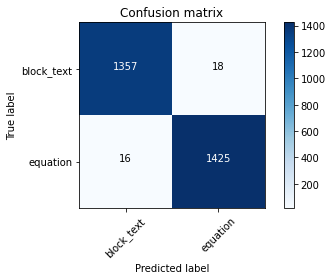

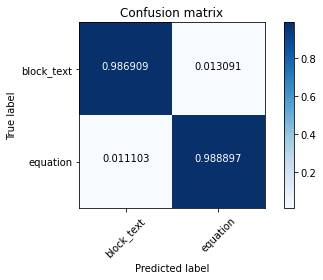

In [ ]:
# Gráfica de la matriz de confusión
cm = confusion_matrix(Label_test, Pred_labels.argmax(axis=1))
cm_plot_labels = ['block_text', 'equation']
plt.figure()
plot_confusion_matrix(cm, cm_plot_labels)
plt.figure()
plot_confusion_matrix(cm, cm_plot_labels, normalize=True)
plt.show()